# Github PR Analysis

**Merge-timeline vs. (Lines of Code | Files Changed)**

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following issue metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined

In [1]:
import psycopg2
import numpy as np
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = (15, 5)
import warnings
warnings.filterwarnings('ignore')

with open("../config_temp.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['augur']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[25440]


# Files + LoC Changes for a PR

We can begin to look at a community's relationship with the population of PRs that they receive by aggregating all PRs. We would like to know what their lifecycle is like and perform some survival analysis on them. Our goal will to be able to observe some patterns about a community's interaction with PRs based on (1) how many lines of code were changed ( added or subtracted ) per PR and (2) how many files were changed. 

In [5]:
df_pr_files = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
					pr.pull_request_id AS pr_id,
                    prf.pr_file_id as file_id,
                    prf.pr_file_additions as additions,
                    prf.pr_file_deletions as deletions,
                    prf.pr_file_additions + prf.pr_file_deletions as total,
                    pr.pr_created_at as created,
                    pr.pr_merged_at as merged,
                    pr.pr_closed_at as closed
                    
                FROM
                	repo r,
                    pull_requests pr,
                    pull_request_files prf

                WHERE
                	r.repo_id = pr.repo_id AND
                    r.repo_id = \'{repo_id}\' AND
                    prf.pull_request_id = pr.pull_request_id
                ORDER BY
                    pr_id
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr_files = pd.concat([df_pr_files, df_current_repo])

df_pr_files = df_pr_files.reset_index()
df_pr_files.drop("index", axis=1, inplace=True)
        
df_pr_files.head(5)

,pr_id,file_id,additions,deletions,total,created,merged,closed
0,210007,46811,86,3,89,2017-01-23 18:50:08,2017-01-23 20:49:42,2017-01-23 20:49:42
1,210008,46606,2,0,2,2017-01-31 17:08:16,2017-01-31 20:09:52,2017-01-31 20:09:52
2,210009,53814,2,0,2,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19
3,210009,53813,2,0,2,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19
4,210009,106809,5,1,6,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19


## Which PRs were closed without being merged?

In [6]:
"""
These are the PRs that were closed without being merged.
"""
df_pr_closed = df_pr_files[df_pr_files['merged'].isna()]
df_pr_closed['close_window'] = df_pr_closed['closed'] - df_pr_closed['created']
df_pr_closed['close_window'] = df_pr_closed['close_window'].apply(lambda d: d.days + 1)
df_pr_closed.head()

,pr_id,file_id,additions,deletions,total,created,merged,closed,close_window
5,210010,39274,3,1,4,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1.0
6,210010,39275,3,1,4,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1.0
7,210010,39273,3,1,4,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1.0
8,210010,39272,3,1,4,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1.0
9,210010,39276,3,1,4,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1.0


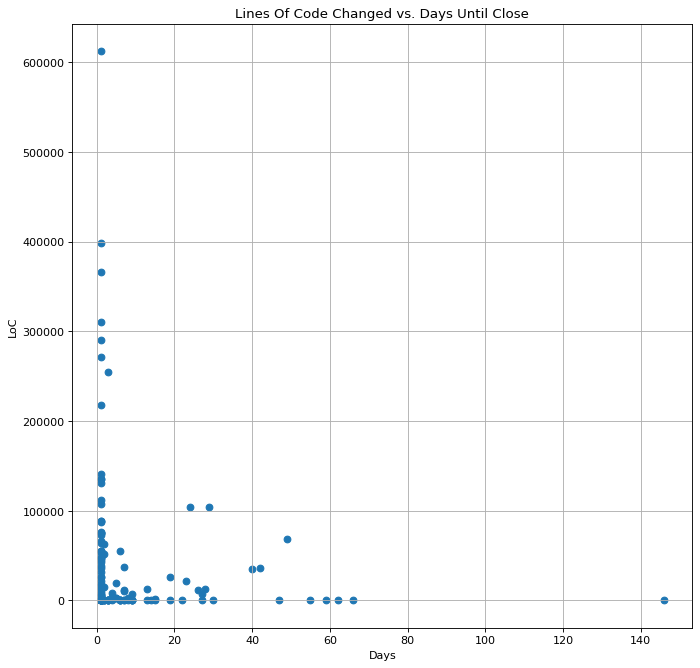

In [7]:
# map the total number of lines changed per PR
df_pr_closed_fc = df_pr_closed.assign(sumChanges = df_pr_closed['pr_id'].map(df_pr_closed.groupby('pr_id')['total'].sum()))

# drop any extra columns so we just see the PR, the days required to merge, and the number of changes made across all files.
df_pr_closed_fc = df_pr_closed_fc.drop(['file_id', 'additions', 'deletions', 'total', 'created', 'merged', 'closed'], axis=1).drop_duplicates('pr_id')

# plot
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df_pr_closed_fc['close_window'], df_pr_closed_fc['sumChanges'])
plt.grid(True)
plt.title("Lines Of Code Changed vs. Days Until Close")
plt.xlabel("Days")
plt.ylabel("LoC")
plt.show()

## Which PRs are still open and how long have they been open?

In [8]:
"""
These are the PRs that have yet to be merged or closed (are still open).
"""
df_pr_open = df_pr_files[df_pr_files['merged'].isna() & df_pr_files['closed'].isna()]
df_pr_open['open_window'] = datetime.now() - df_pr_open['created']
df_pr_open['open_window'] = df_pr_open['open_window'].apply(lambda d: d.days + 1)
df_pr_open.head()

,pr_id,file_id,additions,deletions,total,created,merged,closed,open_window
42296,213921,68594,3,3,6,2020-09-11 00:00:48,NaT,NaT,381
43402,214020,70400,1,0,1,2020-10-12 19:20:28,NaT,NaT,349
43403,214020,70401,1,0,1,2020-10-12 19:20:28,NaT,NaT,349
43404,214020,100242,11,1,12,2020-10-12 19:20:28,NaT,NaT,349
43406,214022,161176,66,58,124,2020-10-14 09:15:54,NaT,NaT,347


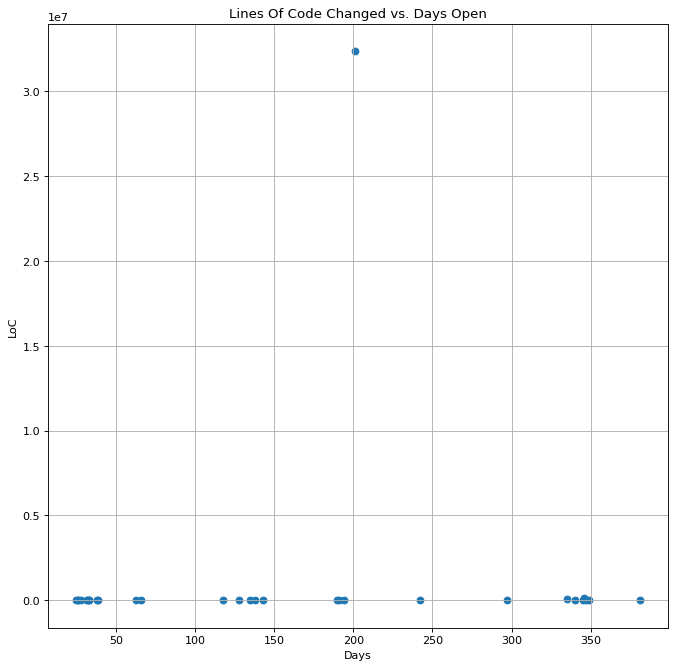

In [9]:
# map the total number of lines changed per PR
df_pr_open_fc = df_pr_open.assign(sumChanges = df_pr_open['pr_id'].map(df_pr_open.groupby('pr_id')['total'].sum()))

# drop any extra columns so we just see the PR, the days required to merge, and the number of changes made across all files.
df_pr_open_fc = df_pr_open_fc.drop(['file_id', 'additions', 'deletions', 'total', 'created', 'merged', 'closed'], axis=1).drop_duplicates('pr_id')

# plot
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df_pr_open_fc['open_window'], df_pr_open_fc['sumChanges'])
plt.grid(True)
plt.title("Lines Of Code Changed vs. Days Open")
plt.xlabel("Days")
plt.ylabel("LoC")
plt.show()

## Which PRs have been merged and closed?

In [10]:
"""
These are the PRs that have been merged and closed.
"""
df_pr_merged = df_pr_files[df_pr_files['merged'].notna()]
df_pr_merged['merge_window'] = df_pr_merged['merged'] - df_pr_merged['created']
df_pr_merged['merge_window'] = df_pr_merged['merge_window'].apply(lambda d: d.days + 1)
df_pr_merged.head(5)

,pr_id,file_id,additions,deletions,total,created,merged,closed,merge_window
0,210007,46811,86,3,89,2017-01-23 18:50:08,2017-01-23 20:49:42,2017-01-23 20:49:42,1
1,210008,46606,2,0,2,2017-01-31 17:08:16,2017-01-31 20:09:52,2017-01-31 20:09:52,1
2,210009,53814,2,0,2,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19,1
3,210009,53813,2,0,2,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19,1
4,210009,106809,5,1,6,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19,1


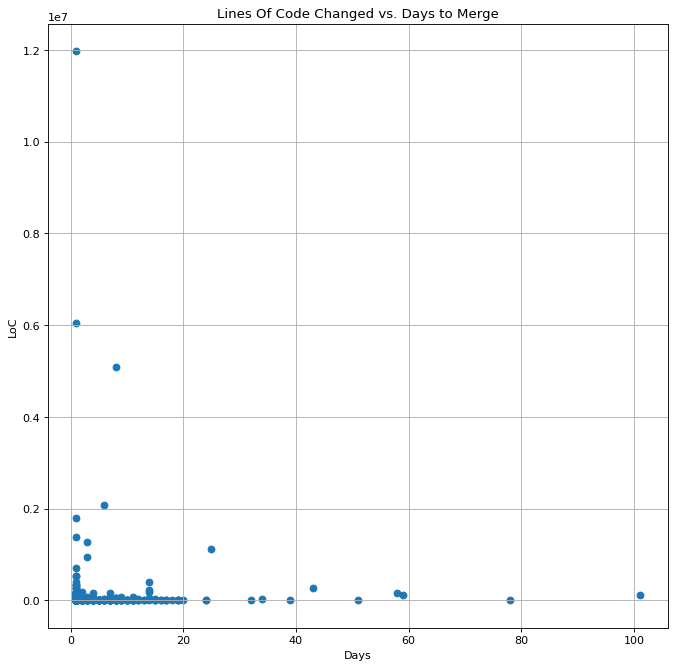

In [11]:
# map the total number of lines changed per PR
df_pr_merged_fc = df_pr_merged.assign(sumChanges = df_pr_merged['pr_id'].map(df_pr_merged.groupby('pr_id')['total'].sum()))

# drop any extra columns so we just see the PR, the days required to merge, and the number of changes made across all files.
df_pr_merged_fc = df_pr_merged_fc.drop(['file_id', 'additions', 'deletions', 'total', 'created', 'merged', 'closed'], axis=1).drop_duplicates('pr_id')

# plot
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df_pr_merged_fc['merge_window'], df_pr_merged_fc['sumChanges'])
plt.grid(True)
plt.title("Lines Of Code Changed vs. Days to Merge")
plt.xlabel("Days")
plt.ylabel("LoC")
plt.show()

## Do LoC correlate visually with time-to-merge (and/or) merge-status?

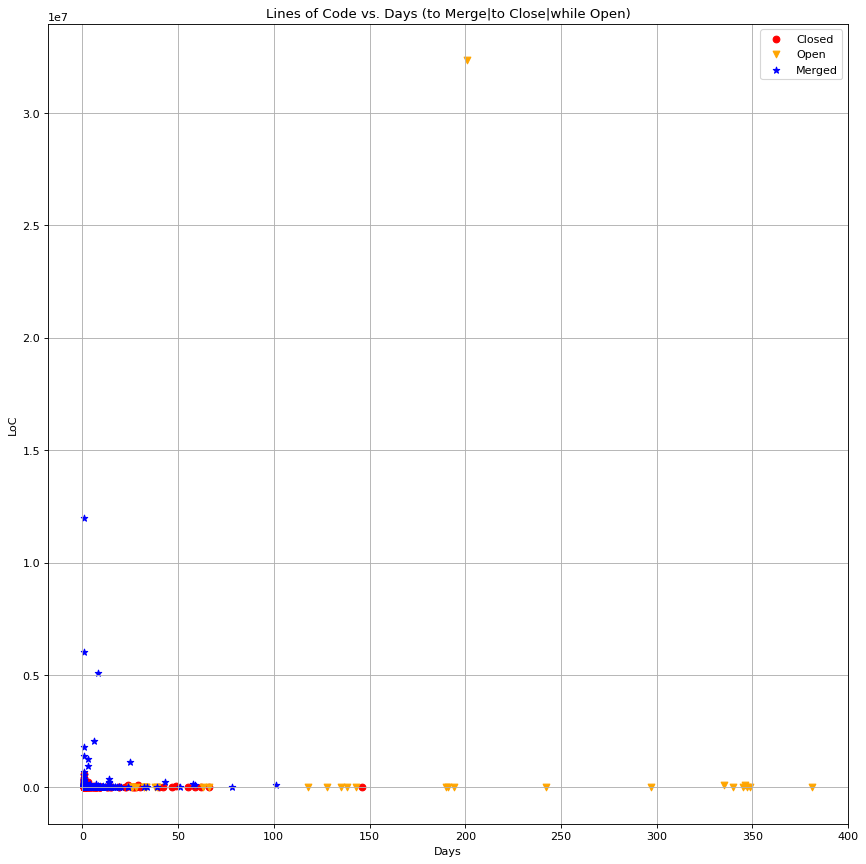

In [20]:
fig = plt.figure( figsize=(10,10), dpi=80 )
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Days")
ax.set_ylabel("LoC")
ax.set_title("Lines of Code vs. Days (to Merge|to Close|while Open)")
ax.grid(True)
ax.scatter( df_pr_closed_fc['close_window'], df_pr_closed_fc['sumChanges'], color='red', marker='o', label="Closed")
ax.scatter( df_pr_open_fc['open_window'], df_pr_open_fc['sumChanges'], color='orange', marker='v', label="Open")
ax.scatter( df_pr_merged_fc['merge_window'], df_pr_merged_fc['sumChanges'], color='blue', marker='*', label="Merged")
ax.legend(["Closed", "Open", "Merged"])

There are some pretty dramatic visual outliers among those PRs that have yet to be merged leading to a pretty sparse plot. We ought to replot the data with some limits on the ranges.


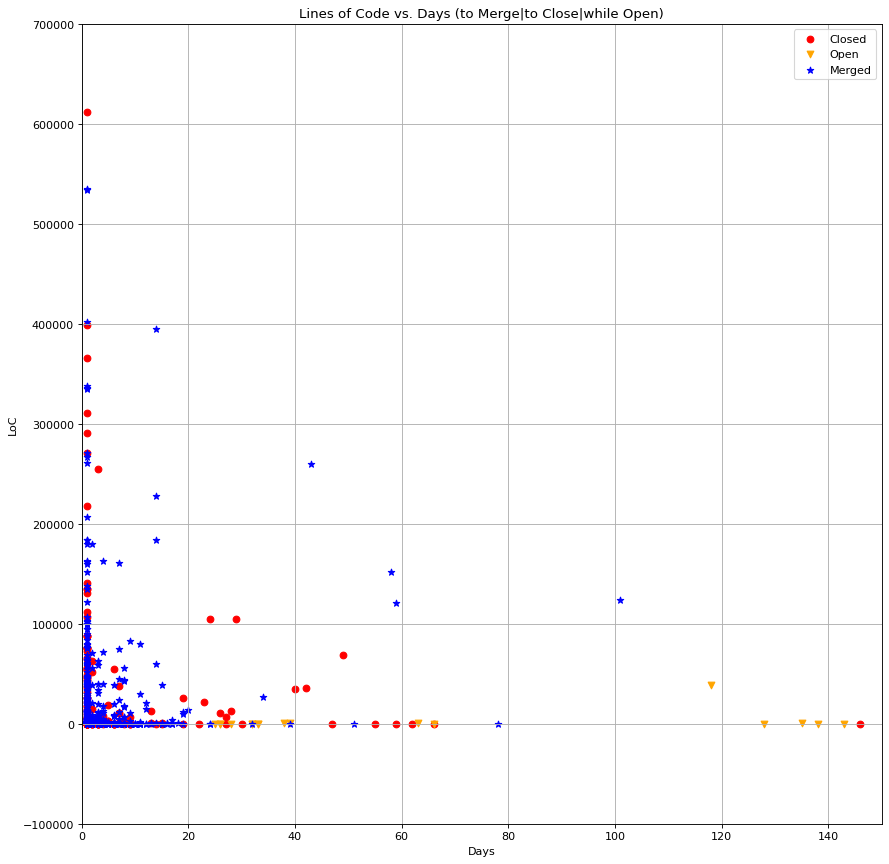

In [30]:
fig2 = plt.figure( figsize=(10,10), dpi=80 )
ax2 = fig2.add_axes([0,0,1,1])
ax2.set_xlabel("Days")
ax2.set_ylabel("LoC")
ax2.set_title("Lines of Code vs. Days (to Merge|to Close|while Open)")
ax2.set_xlim(0,150)
ax2.set_ylim(-100000,0.7e6)
ax2.grid(True)
ax2.scatter( df_pr_closed_fc['close_window'], df_pr_closed_fc['sumChanges'], color='red', marker='o', label="Closed")
ax2.scatter( df_pr_open_fc['open_window'], df_pr_open_fc['sumChanges'], color='orange', marker='v', label="Open")
ax2.scatter( df_pr_merged_fc['merge_window'], df_pr_merged_fc['sumChanges'], color='blue', marker='*', label="Merged")
ax2.legend(["Closed", "Open", "Merged"])

Visually, an overlay of the populations doesn't seem to have very strong correlation. It may be more advantageous to look at the populations statistically. 